新的完整代码

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, re, os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
import itertools
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor


In [2]:
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [3]:
exp = f'resource_stimulus_global_A-B-C_modified'
# exp = f'load_stimulus_global'

In [4]:
chdir = True

In [5]:
import itertools
marker = itertools.cycle(('x',',', '+', '.', 'o', '*'))
cycol = itertools.cycle('bgrcmk')

# Service Chain Configuration

In [6]:
current_dir = os.getcwd()
file_path = os.path.abspath(f'../datasets/{exp}.csv')
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], np.nan)
df = data.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2284 entries, 0 to 45
Data columns (total 63 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   input_rate                          2284 non-null   float64
 1   output_rate                         2284 non-null   float64
 2   firewall_instructions               2284 non-null   float64
 3   nf_router_instructions              2284 non-null   float64
 4   ndpi_stats_instructions             2284 non-null   float64
 5   payload_scan_instructions           2284 non-null   float64
 6   bridge_instructions                 2284 non-null   float64
 7   firewall_branches                   2284 non-null   float64
 8   nf_router_branches                  2284 non-null   float64
 9   ndpi_stats_branches                 2284 non-null   float64
 10  payload_scan_branches               2284 non-null   float64
 11  bridge_branches                     2284 non-

# Correlation coefficients of different features

In [7]:
current_dir = os.getcwd()
# file_path = os.path.abspath(f'../datasets/{exp}.csv')
file_path = os.path.abspath(f'../datasets/{exp}.csv')
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], np.nan)
corr = data.corr()
correlation_list = []
for i in range(1, 2):
    for j in range(i+1, len(corr.columns)):
        correlation_list.append((corr.columns[i], corr.columns[j], abs(corr.iloc[i, j])))


sorted_correlations = sorted(correlation_list, key=lambda x: x[2], reverse=True)

for correlation in sorted_correlations:
    print(f"Correlation between {correlation[0]} and {correlation[1]}: {correlation[2]:.2f}")

Correlation between output_rate and bridge_cache-references: 0.81
Correlation between output_rate and bridge_L1-dcache-load-misses: 0.81
Correlation between output_rate and bridge_LLC-loads: 0.80
Correlation between output_rate and bridge_LLC-stores: 0.80
Correlation between output_rate and payload_scan_LLC-stores: 0.74
Correlation between output_rate and payload_scan_cache-references: 0.73
Correlation between output_rate and payload_scan_L1-dcache-load-misses: 0.72
Correlation between output_rate and payload_scan_LLC-loads: 0.67
Correlation between output_rate and nf_router_LLC-stores: 0.60
Correlation between output_rate and nf_router_L1-dcache-load-misses: 0.58
Correlation between output_rate and nf_router_cache-references: 0.58
Correlation between output_rate and nf_router_LLC-loads: 0.55
Correlation between output_rate and firewall_LLC-loads: 0.54
Correlation between output_rate and ndpi_stats_cache-references: 0.46
Correlation between output_rate and ndpi_stats_L1-dcache-load-mis

In [8]:
# Useful functions for calculate accuracy

def calculate_accuracy_within_threshold(y_true, y_pred, threshold):
    """
    Calculates the accuracy of predictions within a specified threshold.
    
    Parameters:
    - y_true: array-like, true target values.
    - y_pred: array-like, predicted values by the model.
    - threshold: float, the threshold for considering predictions as accurate.
    
    Returns:
    - accuracy_within_threshold: float, the percentage of predictions within the threshold.
    """
    distances = [abs(real - pred) / real if real != 0 else 0 for real, pred in zip(y_true, y_pred)]
    accuracy_within_threshold = sum(dist <= threshold for dist in distances) / len(distances) * 100
    return accuracy_within_threshold

def calculate_accuracy_cdf(y_true, y_pred, max_threshold=1.0, step=0.1):
    """
    Enhanced to output a dictionary mapping each threshold to its corresponding accuracy, 
    this function calculates the cumulative distribution function (CDF) of accuracy across different thresholds.
    
    Parameters:
    - y_true: array-like, true target values.
    - y_pred: array-like, predicted values by the model.
    - max_threshold: float, the maximum threshold to compute the CDF.
    - step: float, the step size to increase the threshold from 0 to max_threshold.
    
    Returns:
    - accuracy_dict: dict, mapping each threshold to its corresponding accuracy within that threshold.
    """
    thresholds = np.arange(0, max_threshold + step, step)
    accuracy_dict = {threshold: calculate_accuracy_within_threshold(y_true, y_pred, threshold) for threshold in thresholds}
    return accuracy_dict




# Compare different stages of ML lifecycles

## A：data without clearning + without feature selection + random model + without hyperparameters tunning 

In [9]:
current_dir = os.getcwd()
# file_path = os.path.abspath(f'../datasets/{exp}.csv')
file_path = os.path.abspath(f'../datasets/{exp}.csv')
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], 0) # without cleaning
df = data.dropna()

In [10]:
# training  
X = df.drop(['input_rate','output_rate', 'latency'], axis=1) # without feature selection
y = df['output_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# ML model
model = LinearRegression()
# train the regressor
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# Evaluate
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

threshold = 0.1
accuracy_within_threshold = calculate_accuracy_within_threshold(y_test, y_pred, threshold)
print(f"Linear Regression Accuracy within {threshold} threshold: {accuracy_within_threshold}%")




R-squared: 0.7066219914166856
Linear Regression Accuracy within 0.1 threshold: 64.57725947521867%


## B. data clean + without feature selection + random model +without hyperparameters tunning 

In [11]:
current_dir = os.getcwd()
file_path = os.path.abspath(f'../datasets/{exp}.csv')
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], np.nan) # data cleaning
df = data.dropna()

In [12]:
# training  
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor 
X = df.drop(['input_rate','output_rate', 'latency'], axis=1) # without feature selection
y = df['output_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# ML model
model = LinearRegression()
# train the regressor
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# Evaluate
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

threshold = 0.1
accuracy_within_threshold = calculate_accuracy_within_threshold(y_test, y_pred, threshold)
print(f"Linear Regression Accuracy within {threshold} threshold: {accuracy_within_threshold}%")



R-squared: 0.7066219914166856
Linear Regression Accuracy within 0.1 threshold: 64.57725947521867%


## C. data clean + with feature selection + random model +without hyperparameters tunning

In [13]:
current_dir = os.getcwd()
file_path = os.path.abspath(f'../datasets/{exp}.csv')
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], np.nan)
df = data.dropna()

### Feature selection

Find the correlation coefficient threshold that makes the r2 score optimal.

Discard features smaller than this correlation coefficient threshold and keep features larger than the correlation coefficient threshold

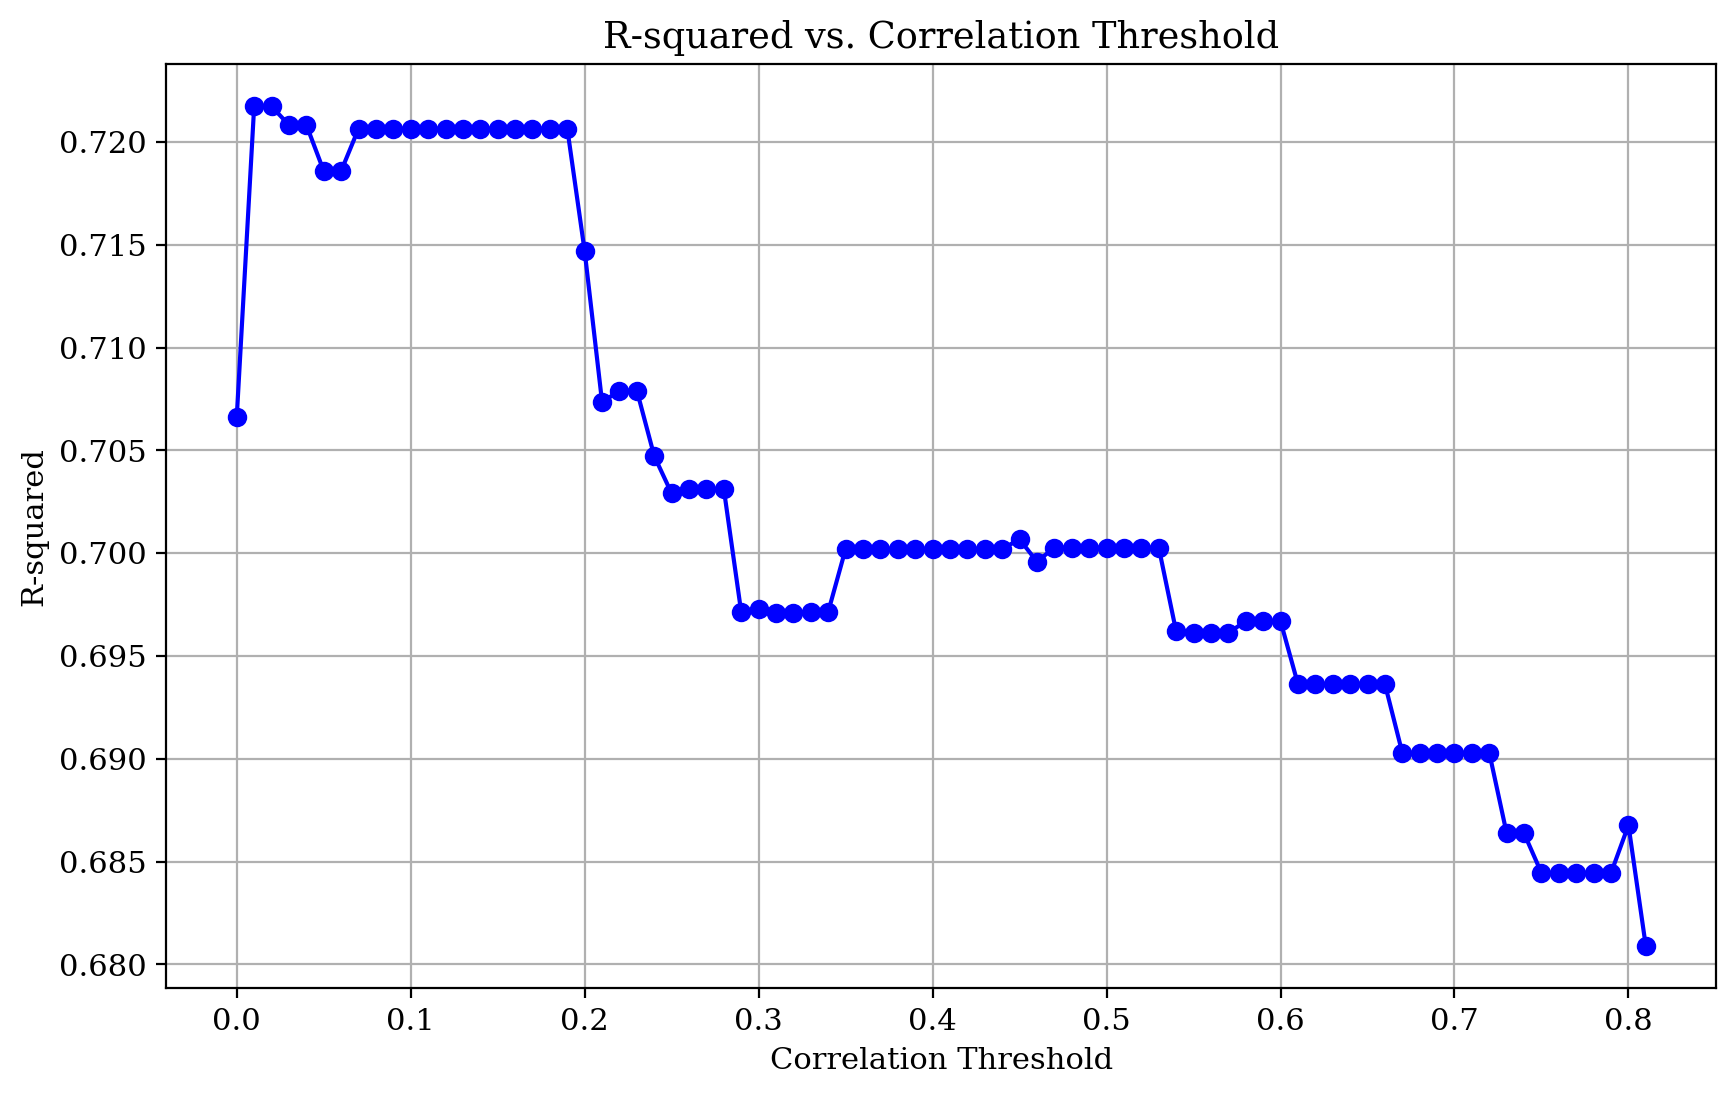

In [14]:
# Initialize the list to store threshold and corresponding R-squared values
thresholds = np.arange(0, 1.01, 0.01)
r2_scores = []

# Loop over thresholds
for threshold in thresholds:
    # Calculate correlations with the target variable ('output_rate')
    corr = df.corrwith(df['output_rate']).abs()

    # Select features based on the current threshold
    selected_features = corr[corr >= threshold].index.tolist()

    # Ensure the target and other non-feature columns are not included in the features list
    selected_features = [feature for feature in selected_features if feature not in ['input_rate', 'output_rate', 'latency']]

    # If no features meet the threshold criteria, continue to the next iteration
    if not selected_features:
        r2_scores.append(None)
        continue

    # Prepare the dataset for model training
    X = df[selected_features]
    y = df['output_rate']

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions and evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)

    # Store the R-squared value
    r2_scores.append(r2)

# Plotting the R-squared values against the correlation thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, r2_scores, marker='o', linestyle='-', color='b')
plt.title('R-squared vs. Correlation Threshold')
plt.xlabel('Correlation Threshold')
plt.ylabel('R-squared')
plt.grid(True)
plt.show()

Select a correlation coefficient threshold of 0.19

In [15]:
# Calculate correlations with the target variable ('output_rate')
corr = df.corrwith(df['output_rate']).abs()

# Filter features with a correlation less than 0.19
selected_features = corr[corr >= 0.19].index.tolist()

# Make sure to exclude the target itself and other non-feature columns if included in selected_features
selected_features = [feature for feature in selected_features if feature not in ['input_rate', 'output_rate', 'latency']]

# Prepare the dataset for training
X = df[selected_features]
# X = df.drop(['input_rate','output_rate', 'latency'], axis=1)
y = df['output_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# ML model
model = LinearRegression()
# train the regressor
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


# Evaluate
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

threshold = 0.1
accuracy_within_threshold = calculate_accuracy_within_threshold(y_test, y_pred, threshold)
print(f"Linear Regression Accuracy within {threshold} threshold: {accuracy_within_threshold}%")


R-squared: 0.7206431916048531
Linear Regression Accuracy within 0.1 threshold: 69.533527696793%


## D. data clean + with feature selection + model selection + hyperparameters tunning  

In [16]:
current_dir = os.getcwd()
file_path = os.path.abspath(f'../datasets/{exp}.csv')
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], np.nan)
df = data.dropna()

### Classical ML models

The chosen classical machine learning model:
- Linear regression
- ridge regression
- support vector machine regression
- Decision tree regression
- Random forest regression
- Gradient Boosting Regressor
- XGBoot

In [17]:
# Prepare the dataset for training
X = df[selected_features]
# X = df.drop(['input_rate','output_rate', 'latency'], axis=1)
y = df['output_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# ML models
# StandardScaler对象
scaler = StandardScaler()

# ML models with standardization
# Linear Regression
model_lr = make_pipeline(scaler, LinearRegression())
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
print("Linear Regression R-squared:", r2_score(y_test, y_pred_lr))

# Ridge Regression
model_ridge = make_pipeline(scaler, Ridge(alpha=1.0)) # alpha is the regularization strength
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)
print("Ridge Regression R-squared:", r2_score(y_test, y_pred_ridge))

# Support Vector Regression (SVR)
model_svr = make_pipeline(scaler, SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
model_svr.fit(X_train, y_train)
y_pred_svr = model_svr.predict(X_test)
print("Support Vector Regression R-squared:", r2_score(y_test, y_pred_svr))

# Decision Tree Regressor
model_dtr = DecisionTreeRegressor(max_depth=5)
model_dtr.fit(X_train, y_train)
y_pred_dtr = model_dtr.predict(X_test)
print("Decision Tree Regressor R-squared:", r2_score(y_test, y_pred_dtr))

# Random Forest Regressor
model_rfr = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model_rfr.fit(X_train, y_train)
y_pred_rfr = model_rfr.predict(X_test)
print("Random Forest Regressor R-squared:", r2_score(y_test, y_pred_rfr))

# Gradient Boosting Regressor
model_gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
model_gbr.fit(X_train, y_train)
y_pred_gbr = model_gbr.predict(X_test)
print("Gradient Boosting Regressor R-squared:", r2_score(y_test, y_pred_gbr))

# XGBoost
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                             max_depth=5, alpha=10, n_estimators=100)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
print("XGBoost R-squared:", r2_score(y_test, y_pred_xgb))

Linear Regression R-squared: 0.7206431916048537
Ridge Regression R-squared: 0.7221843450137327
Support Vector Regression R-squared: 0.6941949561569772
Decision Tree Regressor R-squared: 0.7879120726630557
Random Forest Regressor R-squared: 0.8298052078559717
Gradient Boosting Regressor R-squared: 0.8406769771273027
XGBoost R-squared: 0.8411052347363173


### Calculate accuracy of the predictions

In [18]:
# Calculate accuracy when differences between y_test and y_pred < threshold(0.1)
threshold = 0.1
accuracy_within_threshold_lr = calculate_accuracy_within_threshold(y_test, y_pred_lr, threshold)
print(f"Linear Regression Accuracy within {threshold} threshold: {accuracy_within_threshold_lr}%")

accuracy_within_threshold_ridge = calculate_accuracy_within_threshold(y_test, y_pred_ridge, threshold)
print(f"Ridge Regression Accuracy within {threshold} threshold: {accuracy_within_threshold_ridge}%")

accuracy_within_threshold_svr = calculate_accuracy_within_threshold(y_test, y_pred_svr, threshold)
print(f"Support Vector Regression Accuracy within {threshold} threshold: {accuracy_within_threshold_svr}%")

accuracy_within_threshold_dtr = calculate_accuracy_within_threshold(y_test, y_pred_dtr, threshold)
print(f"Decision Tree Regressor Accuracy within {threshold} threshold: {accuracy_within_threshold_dtr}%")

accuracy_within_threshold_rfr = calculate_accuracy_within_threshold(y_test, y_pred_rfr, threshold)
print(f"Random Forest Regressor Accuracy within {threshold} threshold: {accuracy_within_threshold_rfr}%")

accuracy_within_threshold_gbr = calculate_accuracy_within_threshold(y_test, y_pred_gbr, threshold)
print(f"Gradient Boosting Regressor Accuracy within {threshold} threshold: {accuracy_within_threshold_gbr}%")

accuracy_within_threshold_xgb = calculate_accuracy_within_threshold(y_test, y_pred_xgb, threshold)
print(f"XGBoost Accuracy within {threshold} threshold: {accuracy_within_threshold_xgb}%")



Linear Regression Accuracy within 0.1 threshold: 69.533527696793%
Ridge Regression Accuracy within 0.1 threshold: 74.34402332361516%
Support Vector Regression Accuracy within 0.1 threshold: 89.21282798833819%
Decision Tree Regressor Accuracy within 0.1 threshold: 84.25655976676384%
Random Forest Regressor Accuracy within 0.1 threshold: 83.23615160349854%
Gradient Boosting Regressor Accuracy within 0.1 threshold: 85.56851311953353%
XGBoost Accuracy within 0.1 threshold: 83.52769679300292%


### Find the best threshold for accuracy

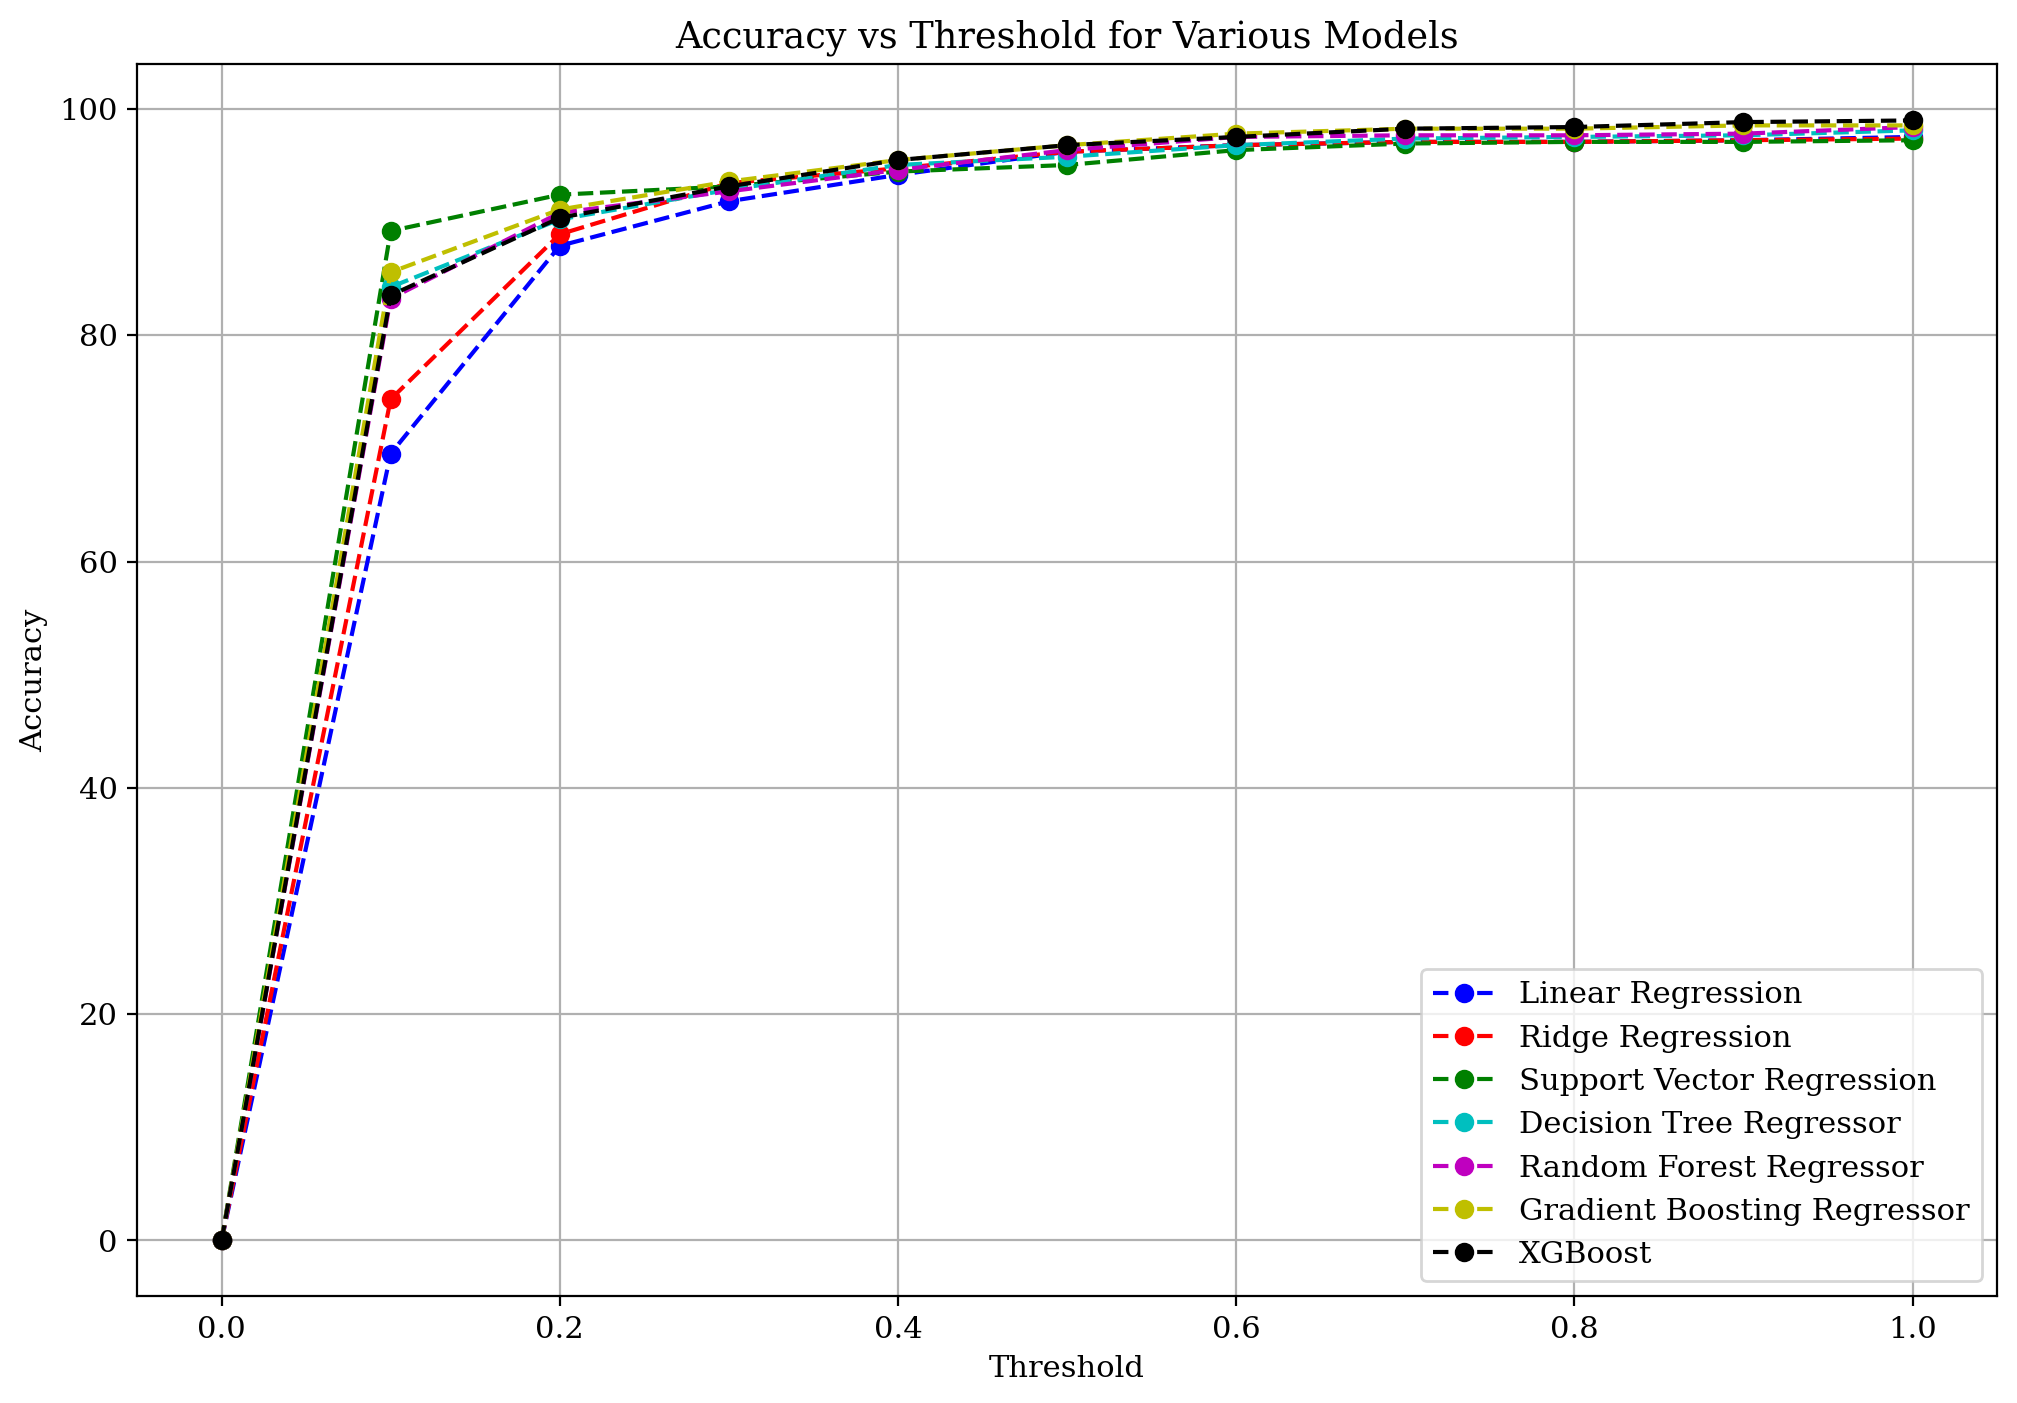

In [19]:
# Assuming y_test, y_pred_lr, y_pred_ridge, y_pred_svr, y_pred_dtr, y_pred_rfr, y_pred_gbr, y_pred_xgb are already defined
accuracy_dict_lr = calculate_accuracy_cdf(y_test, y_pred_lr)
accuracy_dict_ridge = calculate_accuracy_cdf(y_test, y_pred_ridge)
accuracy_dict_svr = calculate_accuracy_cdf(y_test, y_pred_svr)
accuracy_dict_dtr = calculate_accuracy_cdf(y_test, y_pred_dtr)
accuracy_dict_rfr = calculate_accuracy_cdf(y_test, y_pred_rfr)
accuracy_dict_gbr = calculate_accuracy_cdf(y_test, y_pred_gbr)
accuracy_dict_xgb = calculate_accuracy_cdf(y_test, y_pred_xgb)

# Plotting the accuracies
plt.figure(figsize=(12, 8))
thresholds = list(accuracy_dict_lr.keys())
plt.plot(thresholds, list(accuracy_dict_lr.values()), 'b--o', label='Linear Regression')
plt.plot(thresholds, list(accuracy_dict_ridge.values()), 'r--o', label='Ridge Regression')
plt.plot(thresholds, list(accuracy_dict_svr.values()), 'g--o', label='Support Vector Regression')
plt.plot(thresholds, list(accuracy_dict_dtr.values()), 'c--o', label='Decision Tree Regressor')
plt.plot(thresholds, list(accuracy_dict_rfr.values()), 'm--o', label='Random Forest Regressor')
plt.plot(thresholds, list(accuracy_dict_gbr.values()), 'y--o', label='Gradient Boosting Regressor')
plt.plot(thresholds, list(accuracy_dict_xgb.values()), 'k--o', label='XGBoost')

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold for Various Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

A threshold of 0.15 was chosen because within this threshold the accuracy of the different models can be maximally separated

How much of the total range of y_test is occupied by the selection threshold 0.1?

In [20]:
# y_range = max(y_test) - min(y_test)
# threshold = 0.15
# percentage_of_range_covered = (threshold/y_range)*100
# print(f"Threshold of {threshold} covers approximately {percentage_of_range_covered:.2f}% of the overall y_test range")


### Hyperparameter tuning - For classical ML

In [21]:
# Ridge Regression
params_ridge = {'ridge__alpha': [0.1, 1.0, 10.0]}
model_ridge = make_pipeline(StandardScaler(), Ridge())
grid_ridge = GridSearchCV(model_ridge, params_ridge, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)
print("Ridge Regression Best R-squared:", grid_ridge.best_score_)
print("Ridge Regression Best Parameters:", grid_ridge.best_params_)

# Support Vector Regression (SVR)
params_svr = {
    'svr__C': [0.1, 1.0, 10.0],
    'svr__gamma': ['scale', 'auto'],
    'svr__epsilon': [0.01, 0.1, 0.2]
}
model_svr = make_pipeline(StandardScaler(), SVR())
grid_svr = GridSearchCV(model_svr, params_svr, cv=5, scoring='r2')
grid_svr.fit(X_train, y_train)
print("Support Vector Regression Best R-squared:", grid_svr.best_score_)
print("Support Vector Regression Best Parameters:", grid_svr.best_params_)

# For tree-based models, we usually don't need feature scaling.
# Decision Tree Regressor
params_dtr = {'max_depth': [3, 5, 7, 10]}
grid_dtr = GridSearchCV(DecisionTreeRegressor(), params_dtr, cv=5, scoring='r2')
grid_dtr.fit(X_train, y_train)
print("Decision Tree Regressor Best R-squared:", grid_dtr.best_score_)
print("Decision Tree Regressor Best Parameters:", grid_dtr.best_params_)

# Random Forest Regressor
params_rfr = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 10]
}
grid_rfr = GridSearchCV(RandomForestRegressor(random_state=0), params_rfr, cv=5, scoring='r2')
grid_rfr.fit(X_train, y_train)
print("Random Forest Regressor Best R-squared:", grid_rfr.best_score_)
print("Random Forest Regressor Best Parameters:", grid_rfr.best_params_)

# Gradient Boosting Regressor
params_gbr = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_gbr = GridSearchCV(GradientBoostingRegressor(random_state=0), params_gbr, cv=5, scoring='r2')
grid_gbr.fit(X_train, y_train)
print("Gradient Boosting Regressor Best R-squared:", grid_gbr.best_score_)
print("Gradient Boosting Regressor Best Parameters:", grid_gbr.best_params_)

# XGBoost
params_xgb = {
    'xgbregressor__n_estimators': [50, 100, 200],
    'xgbregressor__learning_rate': [0.01, 0.1, 0.2],
    'xgbregressor__max_depth': [3, 5, 7]
}
model_xgb = make_pipeline(xgb.XGBRegressor(objective ='reg:squarederror', random_state=0))
grid_xgb = GridSearchCV(model_xgb, params_xgb, cv=5, scoring='r2')
grid_xgb.fit(X_train, y_train)
print("XGBoost Best R-squared:", grid_xgb.best_score_)
print("XGBoost Best Parameters:", grid_xgb.best_params_)



Ridge Regression Best R-squared: 0.6815642604787753
Ridge Regression Best Parameters: {'ridge__alpha': 0.1}
Support Vector Regression Best R-squared: 0.6297230043350746
Support Vector Regression Best Parameters: {'svr__C': 10.0, 'svr__epsilon': 0.1, 'svr__gamma': 'scale'}
Decision Tree Regressor Best R-squared: 0.7950641557897085
Decision Tree Regressor Best Parameters: {'max_depth': 3}
Random Forest Regressor Best R-squared: 0.8359869315798841
Random Forest Regressor Best Parameters: {'max_depth': 5, 'n_estimators': 200}
Gradient Boosting Regressor Best R-squared: 0.8213413092840136
Gradient Boosting Regressor Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
XGBoost Best R-squared: 0.8280553075442164
XGBoost Best Parameters: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 50}


Get the r2 score of the predictions of the optimal model on the test set

In [22]:
# Ridge Regression
y_pred_ridge = grid_ridge.best_estimator_.predict(X_test)
print("Ridge Regression Test R-squared:", r2_score(y_test, y_pred_ridge))

# Support Vector Regression (SVR)
y_pred_svr = grid_svr.best_estimator_.predict(X_test)
print("Support Vector Regression Test R-squared:", r2_score(y_test, y_pred_svr))

# Decision Tree Regressor
y_pred_dtr = grid_dtr.best_estimator_.predict(X_test)
print("Decision Tree Regressor Test R-squared:", r2_score(y_test, y_pred_dtr))

# Random Forest Regressor
y_pred_rfr = grid_rfr.best_estimator_.predict(X_test)
print("Random Forest Regressor Test R-squared:", r2_score(y_test, y_pred_rfr))

# Gradient Boosting Regressor
y_pred_gbr = grid_gbr.best_estimator_.predict(X_test)
print("Gradient Boosting Regressor Test R-squared:", r2_score(y_test, y_pred_gbr))

# XGBoost
y_pred_xgb = grid_xgb.best_estimator_.predict(X_test)
print("XGBoost Test R-squared:", r2_score(y_test, y_pred_xgb))



Ridge Regression Test R-squared: 0.7216758755053476
Support Vector Regression Test R-squared: 0.6767760102291015
Decision Tree Regressor Test R-squared: 0.8190500282077654
Random Forest Regressor Test R-squared: 0.8306355102867916
Gradient Boosting Regressor Test R-squared: 0.8408810154395628
XGBoost Test R-squared: 0.8374020850563648


Calculate accuracy of the predictions

In [23]:
# Calculate accuracy when differences between y_test and y_pred < threshold(0.1)
threshold = 0.1
accuracy_within_threshold_ridge = calculate_accuracy_within_threshold(y_test, y_pred_ridge, threshold)
print(f"Ridge Regression Accuracy within {threshold} threshold: {accuracy_within_threshold_ridge}%")

accuracy_within_threshold_svr = calculate_accuracy_within_threshold(y_test, y_pred_svr, threshold)
print(f"Support Vector Regression Accuracy within {threshold} threshold: {accuracy_within_threshold_svr}%")

accuracy_within_threshold_dtr = calculate_accuracy_within_threshold(y_test, y_pred_dtr, threshold)
print(f"Decision Tree Regressor Accuracy within {threshold} threshold: {accuracy_within_threshold_dtr}%")

accuracy_within_threshold_rfr = calculate_accuracy_within_threshold(y_test, y_pred_rfr, threshold)
print(f"Random Forest Regressor Accuracy within {threshold} threshold: {accuracy_within_threshold_rfr}%")

accuracy_within_threshold_gbr = calculate_accuracy_within_threshold(y_test, y_pred_gbr, threshold)
print(f"Gradient Boosting Regressor Accuracy within {threshold} threshold: {accuracy_within_threshold_gbr}%")

accuracy_within_threshold_xgb = calculate_accuracy_within_threshold(y_test, y_pred_xgb, threshold)
print(f"XGBoost Accuracy within {threshold} threshold: {accuracy_within_threshold_xgb}%")




Ridge Regression Accuracy within 0.1 threshold: 70.8454810495627%
Support Vector Regression Accuracy within 0.1 threshold: 77.98833819241983%
Decision Tree Regressor Accuracy within 0.1 threshold: 81.04956268221575%
Random Forest Regressor Accuracy within 0.1 threshold: 83.38192419825073%
Gradient Boosting Regressor Accuracy within 0.1 threshold: 83.6734693877551%
XGBoost Accuracy within 0.1 threshold: 83.6734693877551%


### Viewable Comparison of Predicted and Real Results

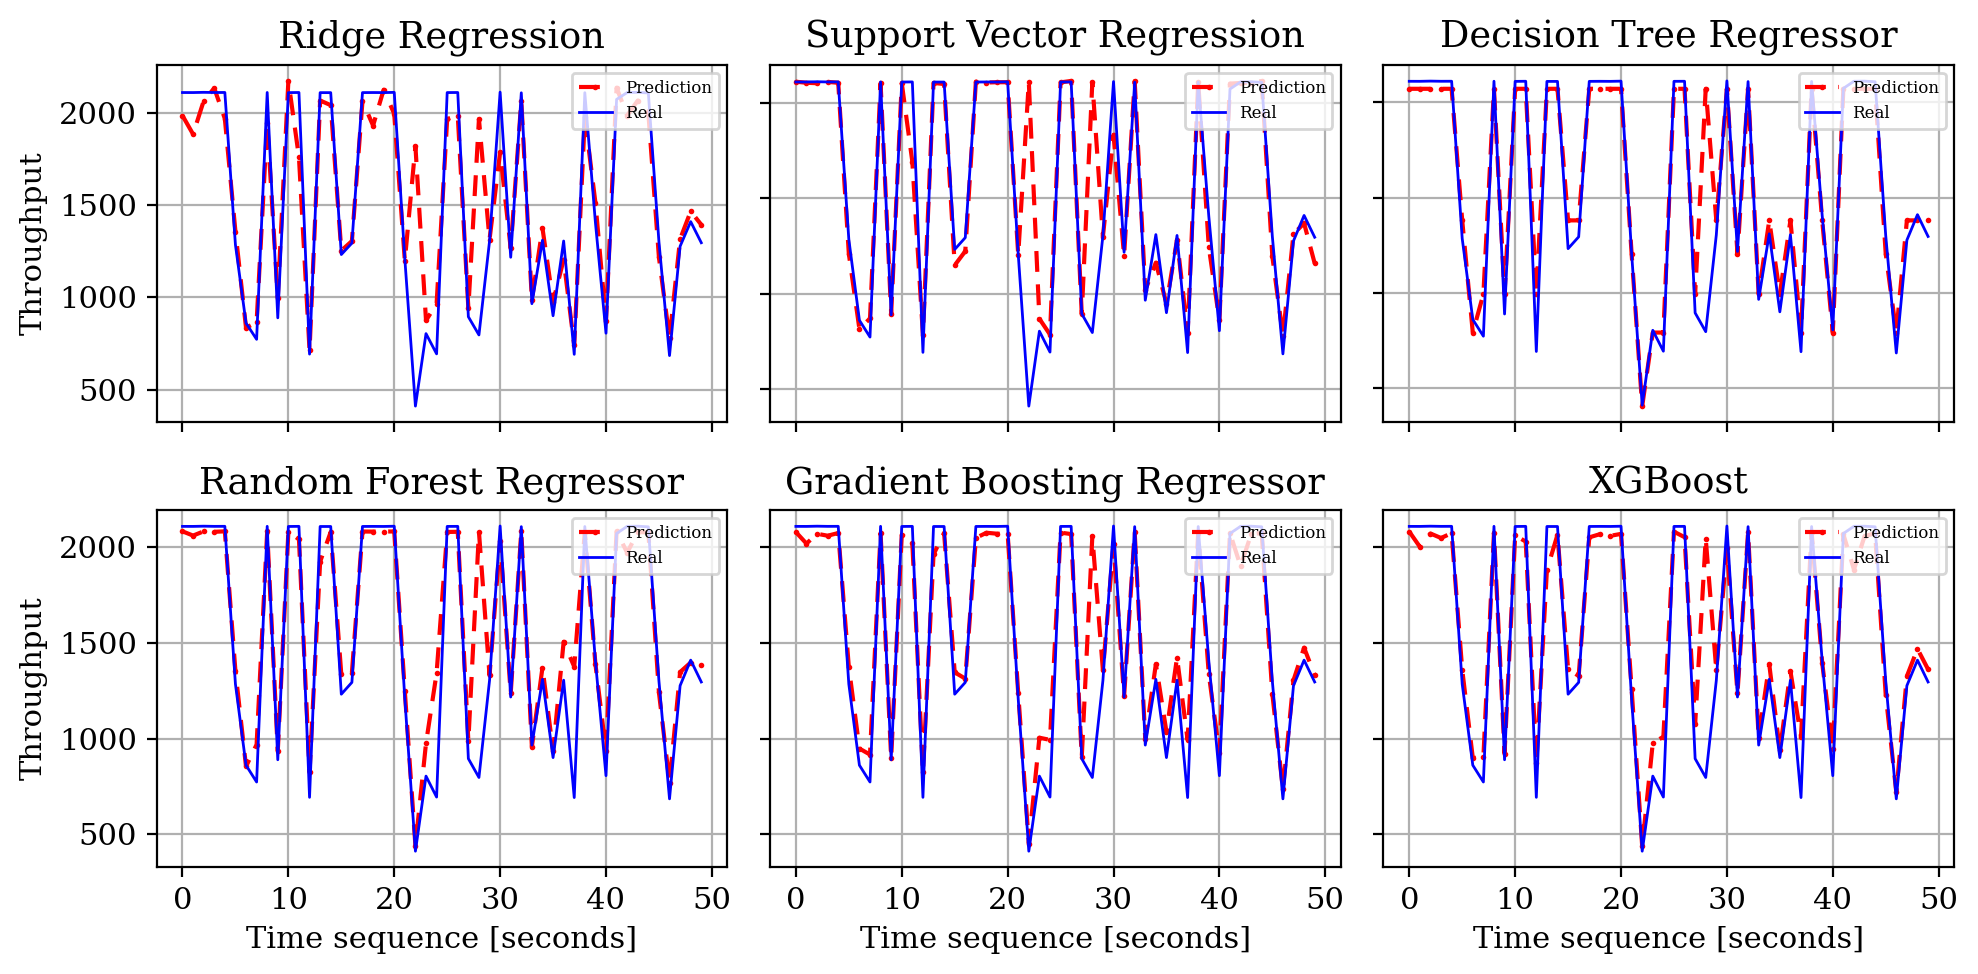

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))  

# Ridge Regression
axs[0, 0].plot(y_pred_ridge[:50], marker='o', c='r', markersize=1, linestyle='-', dashes=(5, 3), label='Prediction')
axs[0, 0].plot(y_test[:50].tolist(), c='b', linestyle='-', linewidth=1, label='Real')
axs[0, 0].set_title('Ridge Regression')
axs[0, 0].legend(loc="upper right", fontsize=6)
axs[0, 0].grid()

# Support Vector Regression
axs[0, 1].plot(y_pred_svr[:50], marker='o', c='r', markersize=1, linestyle='-', dashes=(5, 3), label='Prediction')
axs[0, 1].plot(y_test[:50].tolist(), c='b', linestyle='-', linewidth=1, label='Real')
axs[0, 1].set_title('Support Vector Regression')
axs[0, 1].legend(loc="upper right", fontsize=6)
axs[0, 1].grid()

# Decision Tree Regressor
axs[0, 2].plot(y_pred_dtr[:50], marker='o', c='r', markersize=1, linestyle='-', dashes=(5, 3), label='Prediction')
axs[0, 2].plot(y_test[:50].tolist(), c='b', linestyle='-', linewidth=1, label='Real')
axs[0, 2].set_title('Decision Tree Regressor')
axs[0, 2].legend(loc="upper right", fontsize=6)
axs[0, 2].grid()

# Random Forest Regressor
axs[1, 0].plot(y_pred_rfr[:50], marker='o', c='r', markersize=1, linestyle='-', dashes=(5, 3), label='Prediction')
axs[1, 0].plot(y_test[:50].tolist(), c='b', linestyle='-', linewidth=1, label='Real')
axs[1, 0].set_title('Random Forest Regressor')
axs[1, 0].legend(loc="upper right", fontsize=6)
axs[1, 0].grid()

# Gradient Boosting Regressor
axs[1, 1].plot(y_pred_gbr[:50], marker='o', c='r', markersize=1, linestyle='-', dashes=(5, 3), label='Prediction')
axs[1, 1].plot(y_test[:50].tolist(), c='b', linestyle='-', linewidth=1, label='Real')
axs[1, 1].set_title('Gradient Boosting Regressor')
axs[1, 1].legend(loc="upper right", fontsize=6)
axs[1, 1].grid()

# XGBoost
axs[1, 2].plot(y_pred_xgb[:50], marker='o', c='r', markersize=1, linestyle='-', dashes=(5, 3), label='Prediction')
axs[1, 2].plot(y_test[:50].tolist(), c='b', linestyle='-', linewidth=1, label='Real')
axs[1, 2].set_title('XGBoost')
axs[1, 2].legend(loc="upper right", fontsize=6)
axs[1, 2].grid()

for ax in axs.flat:
    ax.set(xlabel='Time sequence [seconds]', ylabel='Throughput')
    ax.label_outer()  

plt.tight_layout()  
plt.show()



### Prediction using ANN

In [25]:
current_dir = os.getcwd()
file_path = os.path.abspath(f'../datasets/{exp}.csv')
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], np.nan)
df = data.dropna()

In [26]:
X = df[selected_features]
# X = df.drop(['input_rate','output_rate', 'latency'], axis=1)
y = df['output_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

column_order = X_train.columns
X_test = X_test[column_order]

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(len(y))


2284


In [27]:
# model
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))

model.add(Dense(1))

2024-03-20 14:24:30.840722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 14:24:30.849125: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [28]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=1)

Epoch 1/100
100/100 [==============================] - 1s 4ms/step - loss: 1589513.5000
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 287351.7500
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 247591.1875
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 215957.5625
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 191780.8906
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 180560.0625
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 170128.5625
Epoch 8/100
100/100 [==============================] - 0s 4ms/step - loss: 161095.4062
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 155131.5000
Epoch 10/100
100/100 [==============================] - 0s 3ms/step - loss: 149345.7188
Epoch 11/100
100/100 [==============================] - 0s 3ms/step - loss: 144436.8906
Epoch 12/100
100/100 [==================

In [29]:
# Make predictions on the test set
import matplotlib.ticker as mticker

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
 
y_pred=np.array(y_pred)
# (n_samples, 1) -> (n_samples,)
y_pred = [item for subset in y_pred for item in subset]
# y_pred = np.ravel(y_pred)
y_test=np.array(y_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

threshold = 0.1
accuracy_within_threshold = calculate_accuracy_within_threshold(y_test, y_pred, threshold)
print(f"ANN Accuracy within {threshold} threshold: {accuracy_within_threshold}%")


22/22 [==============================] - 0s 3ms/step
R-squared: 0.6880084192386662
ANN Accuracy within 0.1 threshold: 45.91836734693878%


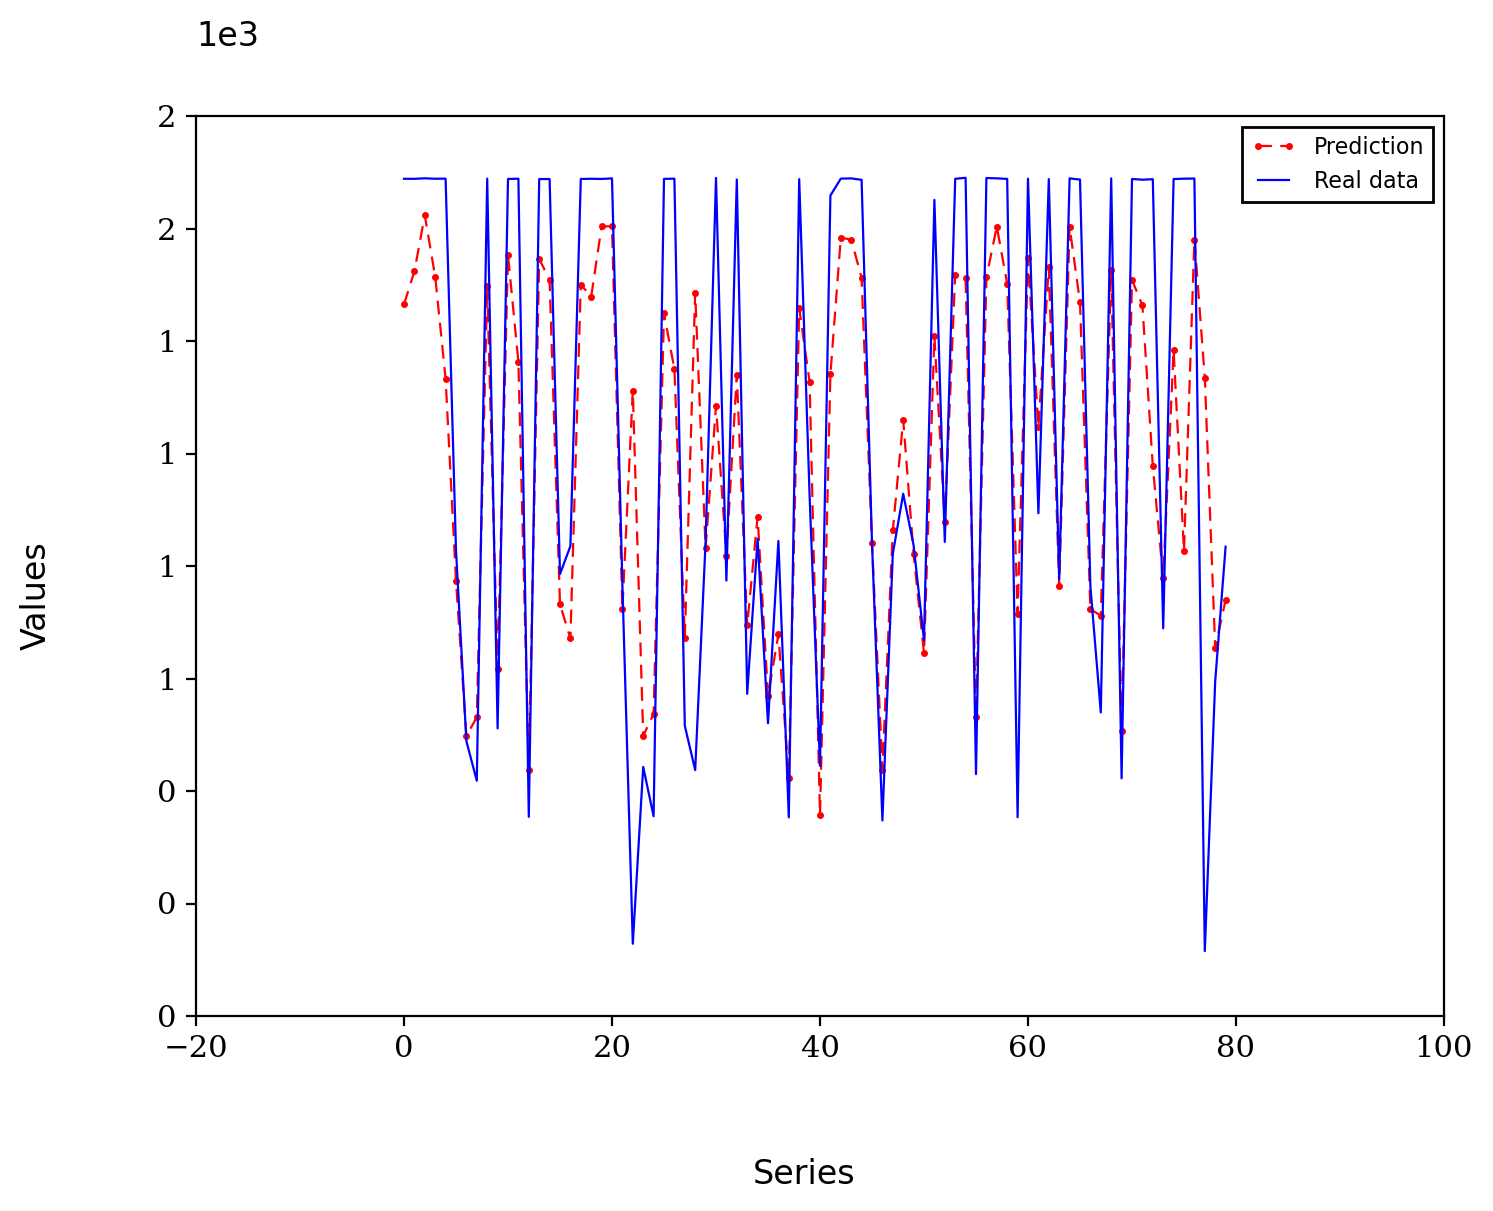

In [30]:
fig, ax = plt.subplots(facecolor='white', figsize=(8,6))
#ax.set_facecolor('white')
plt.style.use('classic')

plt.plot(y_pred[0:80], marker='o',c='r',markersize = 2, linewidth = 0.8, linestyle='-', markeredgecolor='red', dashes=(5, 3),label='Prediction')
plt.plot(y_test.tolist()[0:80], c='b',linestyle='-',linewidth = 0.8,label='Real data')


plt.legend(loc="upper right", fontsize=8)
fig.text(0.5, 0.01, 'Series', size='12', ha='center')
fig.text(0.01, 0.5, 'Values', size='12', va='center', rotation='vertical')
plt.subplots_adjust(left=0.12, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.4)
#plt.grid()
ax.set_facecolor('white')

# Set y-axis tick format
formatter = mticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}")
ax.yaxis.set_major_formatter(formatter)
# Set text in the upper left corner of the figure
fig.text(0.12, 0.98, '1e3', size='12', ha='left', va='top')


plt.show()

In [31]:
# read the CSV file
path = ('../linear/datasets/resource_stimulus_global_A-B-C.csv')

df = pd.read_csv(path)
df = df.replace(['<not counted>'], np.nan)
df = df.dropna()
data2 = df

# separate the features and target variable
# X_test = df.drop(['Unnamed: 0','input_rate', 'output_rate', 'latency'], axis=1)
# X_test = df.drop(['Unnamed: 0','input_rate','output_rate', 'latency','firewall_cycles','payload_scan_cycles','ndpi_stats_branch-load-misses',
#              'nf_router_cycles','bridge_cycles','payload_scan_LLC-load-misses','payload_scan_LLC-load-misses','bridge_LLC-load-misses',
#              'bridge_cache-misses','bridge_cache-misses','nf_router_cache-misses','firewall_cache-misses','nf_router_LLC-load-misses',
#              'ndpi_stats_LLC-load-misses','nf_router_branch-load-misses','nf_router_branch-misses','payload_scan_branch-load-misses',
#              'payload_scan_branch-misses','bridge_branch-misses','ndpi_stats_branch-load-misses','ndpi_stats_cache-misses','firewall_branch-misses'], axis=1)
X_test = df[selected_features]
y_test =df['output_rate'].values

# standardize the features
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

# evaluate
y_pred = model.predict(X_test)
y_pred = np.array(y_pred)
mse = mean_squared_error(y_test, y_pred)

# accuracy
threshold = 0.1
accuracy_new = calculate_accuracy_within_threshold(y_test, y_pred, threshold)
print(f'accurancy with thoreshold 0.15: {accuracy_new[0]}%')

70/70 [==============================] - 0s 3ms/step
accurancy with thoreshold 0.15: 50.602947744528805%


### Hyperparameter tuning - For ANN

In [32]:
def create_model(learning_rate=0.01, neurons_layer1=16, neurons_layer2=16):
    model = Sequential()
    model.add(Dense(neurons_layer1, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(neurons_layer2, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)
param_grid = {
    'batch_size': [4, 8, 16, 32, 64],
    'epochs': [20, 50, 100, 150],
    'learning_rate': [0.1, 0.01, 0.001],
    'neurons_layer1': [16, 32, 64],
    'neurons_layer2': [16, 32, 64]
}
# from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/tmp/ipykernel_865336/4066578601.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)
2024-03-20 14:25:20.146632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 14:25:20.146632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Best: -92660.978125 using {'batch_size': 8, 'epochs': 150, 'learning_rate': 0.01, 'neurons_layer1': 32, 'neurons_layer2': 64}


In [33]:
# 使用最佳模型进行预测
y_pred = grid_result.best_estimator_.predict(X_test)

# 计算测试集上的性能指标
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Test MSE:", mse_test)
print("Test R-squared:", r2_test)

threshold = 0.1
accuracy_within_threshold = calculate_accuracy_within_threshold(y_test, y_pred, threshold)
print(f"ANN Accuracy within {threshold} threshold: {accuracy_within_threshold}%")




Test MSE: 71137.60412309063
Test R-squared: 0.7778757202841204
ANN Accuracy within 0.1 threshold: 80.88432335864225%


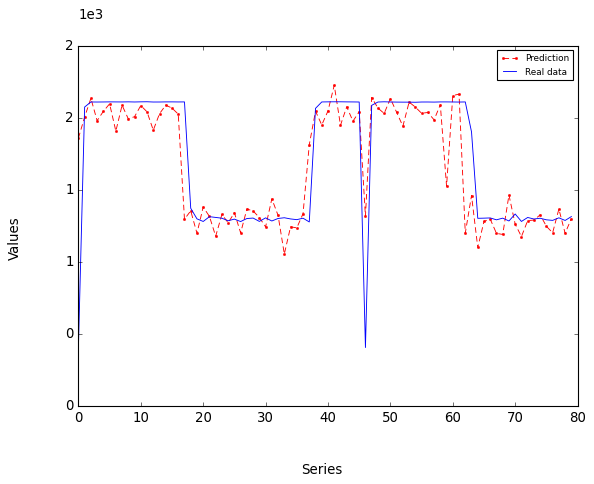

In [34]:
fig, ax = plt.subplots(facecolor='white', figsize=(8,6))
#ax.set_facecolor('white')
plt.style.use('classic')

plt.plot(y_pred[0:80], marker='o',c='r',markersize = 2, linewidth = 0.8, linestyle='-', markeredgecolor='red', dashes=(5, 3),label='Prediction')
plt.plot(y_test.tolist()[0:80], c='b',linestyle='-',linewidth = 0.8,label='Real data')


plt.legend(loc="upper right", fontsize=8)
fig.text(0.5, 0.01, 'Series', size='12', ha='center')
fig.text(0.01, 0.5, 'Values', size='12', va='center', rotation='vertical')
plt.subplots_adjust(left=0.12, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.4)
#plt.grid()
ax.set_facecolor('white')

# Set y-axis tick format
formatter = mticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}")
ax.yaxis.set_major_formatter(formatter)
# Set text in the upper left corner of the figure
fig.text(0.12, 0.98, '1e3', size='12', ha='left', va='top')


plt.show()

In [38]:
# read the CSV file
path = ('../linear/datasets/resource_stimulus_global_A-B-C.csv')

df = pd.read_csv(path)
df = df.replace(['<not counted>'], np.nan)
df = df.dropna()
data2 = df

# separate the features and target variable
# X_test = df.drop(['Unnamed: 0','input_rate', 'output_rate', 'latency'], axis=1)
# X_test = df.drop(['Unnamed: 0','input_rate','output_rate', 'latency','firewall_cycles','payload_scan_cycles','ndpi_stats_branch-load-misses',
#              'nf_router_cycles','bridge_cycles','payload_scan_LLC-load-misses','payload_scan_LLC-load-misses','bridge_LLC-load-misses',
#              'bridge_cache-misses','bridge_cache-misses','nf_router_cache-misses','firewall_cache-misses','nf_router_LLC-load-misses',
#              'ndpi_stats_LLC-load-misses','nf_router_branch-load-misses','nf_router_branch-misses','payload_scan_branch-load-misses',
#              'payload_scan_branch-misses','bridge_branch-misses','ndpi_stats_branch-load-misses','ndpi_stats_cache-misses','firewall_branch-misses'], axis=1)
X_test = df[selected_features]
y_test =df['output_rate'].values

# standardize the features
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

# evaluate
y_pred = grid_result.best_estimator_.predict(X_test)
y_pred = np.array(y_pred)
mse = mean_squared_error(y_test, y_pred)

# accuracy
threshold = 0.1
accuracy_new = calculate_accuracy_within_threshold(y_test, y_pred, threshold)
print(f'accurancy with thoreshold 0.1: {accuracy_new}%')

accurancy with thoreshold 0.1: 80.88432335864225%


## Optimal

In [39]:
current_dir = os.getcwd()
file_path = os.path.abspath(f'../datasets/{exp}.csv')
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], np.nan)
df = data.dropna()

In [40]:
X = df[selected_features]
# X = df.drop(['input_rate','output_rate', 'latency'], axis=1)
y = df['output_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(len(y))


2284


In [41]:
# model
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))

# Add input layer and hidden layers with L2 regularization
# model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# Add output layer
model.add(Dense(1))

In [42]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=8, epochs=100, verbose=1)

Epoch 1/100
200/200 [==============================] - 1s 4ms/step - loss: 1185407.7500
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 209028.1875
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 182239.0938
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 165602.8281
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 154526.0938
Epoch 6/100
200/200 [==============================] - 1s 4ms/step - loss: 146530.4688
Epoch 7/100
200/200 [==============================] - 1s 4ms/step - loss: 143276.0000
Epoch 8/100
200/200 [==============================] - 1s 4ms/step - loss: 136212.2500
Epoch 9/100
200/200 [==============================] - 1s 4ms/step - loss: 132432.0625
Epoch 10/100
200/200 [==============================] - 1s 3ms/step - loss: 128779.3203
Epoch 11/100
200/200 [==============================] - 1s 4ms/step - loss: 126983.5625
Epoch 12/100
200/200 [==================

In [43]:
y_pred = model.predict(X_test)

r2_test = r2_score(y_test, y_pred)
print("Test R-squared:", r2_test)

threshold = 0.1
accuracy_within_threshold = calculate_accuracy_within_threshold(y_test, y_pred, threshold)
print(f"ANN Accuracy within {threshold} threshold: {accuracy_within_threshold[0]}%")


22/22 [==============================] - 0s 4ms/step
Test R-squared: 0.6874838969068097
ANN Accuracy within 0.1 threshold: 67.93002915451895%


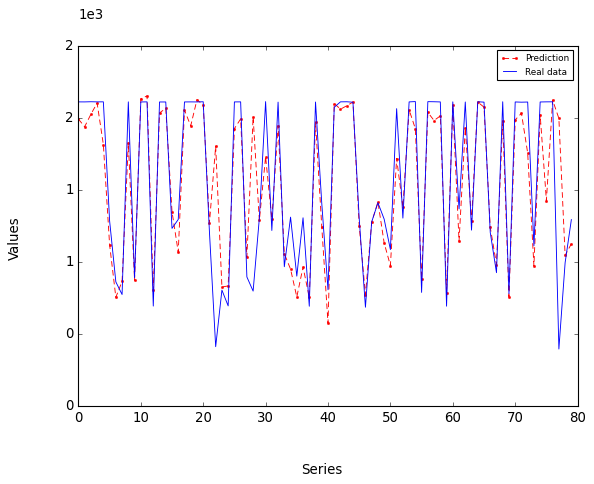

In [44]:
fig, ax = plt.subplots(facecolor='white', figsize=(8,6))
#ax.set_facecolor('white')
plt.style.use('classic')

plt.plot(y_pred[0:80], marker='o',c='r',markersize = 2, linewidth = 0.8, linestyle='-', markeredgecolor='red', dashes=(5, 3),label='Prediction')
plt.plot(y_test.tolist()[0:80], c='b',linestyle='-',linewidth = 0.8,label='Real data')


plt.legend(loc="upper right", fontsize=8)
fig.text(0.5, 0.01, 'Series', size='12', ha='center')
fig.text(0.01, 0.5, 'Values', size='12', va='center', rotation='vertical')
plt.subplots_adjust(left=0.12, right=0.9, bottom=0.15, top=0.9, wspace=0.3, hspace=0.4)
#plt.grid()
ax.set_facecolor('white')

# Set y-axis tick format
formatter = mticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}")
ax.yaxis.set_major_formatter(formatter)
# Set text in the upper left corner of the figure
fig.text(0.12, 0.98, '1e3', size='12', ha='left', va='top')


plt.show()

In [46]:
# read the CSV file
path = ('../linear/datasets/resource_stimulus_global_A-B-C.csv')

df = pd.read_csv(path)
df = df.replace(['<not counted>'], np.nan)
df = df.dropna()
data2 = df

# separate the features and target variable
# X_test = df.drop(['Unnamed: 0','input_rate', 'output_rate', 'latency'], axis=1)
# X_test = df.drop(['Unnamed: 0','input_rate','output_rate', 'latency','firewall_cycles','payload_scan_cycles','ndpi_stats_branch-load-misses',
#              'nf_router_cycles','bridge_cycles','payload_scan_LLC-load-misses','payload_scan_LLC-load-misses','bridge_LLC-load-misses',
#              'bridge_cache-misses','bridge_cache-misses','nf_router_cache-misses','firewall_cache-misses','nf_router_LLC-load-misses',
#              'ndpi_stats_LLC-load-misses','nf_router_branch-load-misses','nf_router_branch-misses','payload_scan_branch-load-misses',
#              'payload_scan_branch-misses','bridge_branch-misses','ndpi_stats_branch-load-misses','ndpi_stats_cache-misses','firewall_branch-misses'], axis=1)
X_test = df[selected_features]
y_test =df['output_rate'].values

# standardize the features
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

# evaluate
y_pred = model.predict(X_test)
y_pred = np.array(y_pred)
mse = mean_squared_error(y_test, y_pred)

# accuracy
threshold = 0.1
accuracy_new = calculate_accuracy_within_threshold(y_test, y_pred, threshold)
print(f'accurancy with thoreshold 0.15: {accuracy_new[0]}%')

70/70 [==============================] - 0s 3ms/step
accurancy with thoreshold 0.15: 69.71862438588656%


# Results

## Train with bridge-resource-stimulus (threshold=0.15)

In [ ]:
import matplotlib.pyplot as plt

# Data to be plotted

# performance = [76,82,87,88,96]
performance = [77,77,81,83,84]
steps = ['Step 1', 'Step 2', 'Step 3', 'Step 4', 'Step 5']

# Plotting the step pipeline
fig, ax = plt.subplots(facecolor='white', figsize=(7, 2.5))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.step(steps, performance, where='mid', linewidth=2, marker='o')
#plt.xlabel('Steps')
plt.ylabel('Accuracy (%)')
#plt.title('Performance Improvement at Each Step')
#plt.ylim(60, 100)  # Setting the y-axis limits to better visualize the performance

# Adding the performance values on top of each point
for x, y in zip(steps, performance):
    plt.text(x, y + 1, f'{y}%', ha='center')

plt.grid(True)
plt.savefig('accuracy_step.pdf',bbox_inches='tight')
plt.show()




## Train with bridge-load-stimulus (threshold=0.5)

In [ ]:
import matplotlib.pyplot as plt

# Data to be plotted

# performance = [76,82,87,88,96]
performance = [75,75,75,83,86] #??
steps = ['Step 1', 'Step 2', 'Step 3', 'Step 4', 'Step 5']

# Plotting the step pipeline
fig, ax = plt.subplots(facecolor='white', figsize=(7, 2.5))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.step(steps, performance, where='mid', linewidth=2, marker='o')
#plt.xlabel('Steps')
plt.ylabel('Accuracy (%)')
#plt.title('Performance Improvement at Each Step')
#plt.ylim(60, 100)  # Setting the y-axis limits to better visualize the performance

# Adding the performance values on top of each point
for x, y in zip(steps, performance):
    plt.text(x, y + 1, f'{y}%', ha='center')

plt.grid(True)
plt.savefig('accuracy_step.pdf',bbox_inches='tight')
plt.show()




## Train with bridge-load-stimulus (threshold=0.15)

In [ ]:
import matplotlib.pyplot as plt

# Data to be plotted

# performance = [76,82,87,88,96]
performance = [36,36,36,51,54] #??
steps = ['Step 1', 'Step 2', 'Step 3', 'Step 4', 'Step 5']

# Plotting the step pipeline
fig, ax = plt.subplots(facecolor='white', figsize=(7, 2.5))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.step(steps, performance, where='mid', linewidth=2, marker='o')
#plt.xlabel('Steps')
plt.ylabel('Accuracy (%)')
#plt.title('Performance Improvement at Each Step')
#plt.ylim(60, 100)  # Setting the y-axis limits to better visualize the performance

# Adding the performance values on top of each point
for x, y in zip(steps, performance):
    plt.text(x, y + 1, f'{y}%', ha='center')

plt.grid(True)
plt.savefig('accuracy_step.pdf',bbox_inches='tight')
plt.show()





## Train with linear-resource-stimulus (threshold=0.15)

In [ ]:
# Data to be plotted

# performance = [76,82,87,88,96]
performance = [78,78,81,82,84]
steps = ['Step 1', 'Step 2', 'Step 3', 'Step 4', 'Step 5']

# Plotting the step pipeline
fig, ax = plt.subplots(facecolor='white', figsize=(7, 2.5))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.step(steps, performance, where='mid', linewidth=2, marker='o')
#plt.xlabel('Steps')
plt.ylabel('Accuracy (%)')
# plt.title('Performance Improvement at Each Step')
# plt.ylim(60, 100)  # Setting the y-axis limits to better visualize the performance

# Adding the performance values on top of each point
for x, y in zip(steps, performance):
    plt.text(x, y + 1, f'{y}%', ha='center')

plt.grid(True)
plt.savefig('accuracy_step.pdf',bbox_inches='tight')
plt.show()





## Train with linear-load-stimulus (threshold=0.15)

In [ ]:
import matplotlib.pyplot as plt

# Data to be plotted

# performance = [76,82,87,88,96]
performance = [89,89,89,90,87] #??
steps = ['Step 1', 'Step 2', 'Step 3', 'Step 4', 'Step 5']

# Plotting the step pipeline
fig, ax = plt.subplots(facecolor='white', figsize=(7, 2.5))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.step(steps, performance, where='mid', linewidth=2, marker='o')
#plt.xlabel('Steps')
plt.ylabel('Accuracy (%)')
#plt.title('Performance Improvement at Each Step')
#plt.ylim(60, 100)  # Setting the y-axis limits to better visualize the performance

# Adding the performance values on top of each point
for x, y in zip(steps, performance):
    plt.text(x, y + 1, f'{y}%', ha='center')

plt.grid(True)
plt.savefig('accuracy_step.pdf',bbox_inches='tight')
plt.show()





# Drift detection

In [ ]:
current_dir = os.getcwd()
file_path = os.path.abspath(f'../linear/datasets/{exp}.csv')
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], np.nan)
df = data.dropna()

In [ ]:
data1 = df

In [ ]:
corr = df.corrwith(df['output_rate']).abs()
selected_features = corr[corr >= 0.19].index.tolist()
selected_features = [feature for feature in selected_features if feature not in ['input_rate', 'output_rate', 'latency']]

X = df[selected_features]
# X = df.drop(['input_rate','output_rate', 'latency'], axis=1)
y = df['output_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(len(y))



In [ ]:
# model
model = Sequential()

# Add input layer and hidden layers
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))

model.add(Dense(1))

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=8, epochs=100, verbose=1)

In [ ]:
y_pred = model.predict(X_test)

r2_test = r2_score(y_test, y_pred)
print("Test R-squared:", r2_test)

threshold = 0.15
accuracy_within_threshold = calculate_accuracy_within_threshold(y_test, y_pred, threshold)
print(f"ANN Accuracy within {threshold} threshold: {accuracy_within_threshold[0]}%")



In [ ]:
# read the CSV file
path = ('../Dag/dag-1/datasets/resource_stimulus_global_A-B-C.csv')

df = pd.read_csv(path)
df = df.replace(['<not counted>'], np.nan)
df = df.dropna()
data2 = df

# separate the features and target variable
# X_test = df.drop(['Unnamed: 0','input_rate', 'output_rate', 'latency'], axis=1)
# X_test = df.drop(['Unnamed: 0','input_rate','output_rate', 'latency','firewall_cycles','payload_scan_cycles','ndpi_stats_branch-load-misses',
#              'nf_router_cycles','bridge_cycles','payload_scan_LLC-load-misses','payload_scan_LLC-load-misses','bridge_LLC-load-misses',
#              'bridge_cache-misses','bridge_cache-misses','nf_router_cache-misses','firewall_cache-misses','nf_router_LLC-load-misses',
#              'ndpi_stats_LLC-load-misses','nf_router_branch-load-misses','nf_router_branch-misses','payload_scan_branch-load-misses',
#              'payload_scan_branch-misses','bridge_branch-misses','ndpi_stats_branch-load-misses','ndpi_stats_cache-misses','firewall_branch-misses'], axis=1)
X_test = df[selected_features]
y_test =df['output_rate'].values

# standardize the features
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

# evaluate
y_pred = model.predict(X_test)
y_pred = np.array(y_pred)
mse = mean_squared_error(y_test, y_pred)

# accuracy
threshold = 0.15
accuracy_new = calculate_accuracy_within_threshold(y_test, y_pred, threshold)
print(f'accurancy with thoreshold 0.15: {accuracy_new[0]}%')

In [ ]:
from scipy.spatial.distance import jensenshannon
# Function to compute JS divergence between two distributions
def js_divergence(p, q):
    return jensenshannon(p, q)**2

# Function to compare JS divergence across all CPU-related features
def calculate_js_divergence_between_datasets(data1, data2, cpu_related_features):
    js_divergences = {}
    for feature in cpu_related_features:
        # Ensure the feature is in both datasets
        if feature in data1.columns and feature in data2.columns:
            # Convert data to probability distributions using histograms
            p_hist, _ = np.histogram(data1[feature], bins=30, range=(min(data1[feature].min(), data2[feature].min()), 
                              max(data1[feature].max(), data2[feature].max())), density=True)
            q_hist, _ = np.histogram(data2[feature], bins=30, range=(min(data1[feature].min(), data2[feature].min()), 
                              max(data1[feature].max(), data2[feature].max())), density=True)
            # Calculate JS divergence
            js_div = js_divergence(p_hist, q_hist)
            js_divergences[feature] = js_div
    return js_divergences

In [ ]:
# Calculate the drop in accuracy
accuracy_drop = accuracy_within_threshold - accuracy_new

# Check if the drop in accuracy is more than 5 percentage points
if accuracy_drop > 5:
    # Identify CPU-related features, excluding certain features
    cpu_related_features = [col for col in df.columns if 'instructions' in col or 'cycles' in col or 'cache' in col or 'branches' in col]
    cpu_related_features = [feature for feature in cpu_related_features if feature not in ['input_rate', 'output_rate', 'latency']]
    
    # Calculate JS divergence for each CPU-related feature
    js_divergences = calculate_js_divergence_between_datasets(data1, data2, cpu_related_features)
    
    # Sort features by JS divergence in descending order
    sorted_js_divergences = dict(sorted(js_divergences.items(), key=lambda item: item[1], reverse=True))
    
    # Output the JS divergence values in sorted order
    for feature, js_div in sorted_js_divergences.items():
        print(f"{feature}: JS Divergence: {js_div:.3f}")

# Evaluating generalisation capabilities

In [47]:
current_dir = os.getcwd()
file_path = os.path.abspath(f'../datasets/{exp}.csv')
data = pd.read_csv(file_path, index_col=0)
data = data.replace(['<not counted>'], np.nan)
df = data.dropna()

In [48]:
data1 = df

In [49]:
corr = df.corrwith(df['output_rate']).abs()
selected_features = corr[corr >= 0.19].index.tolist()
selected_features = [feature for feature in selected_features if feature not in ['input_rate', 'output_rate', 'latency']]

X = df[selected_features]
# X = df.drop(['input_rate','output_rate', 'latency'], axis=1)
y = df['output_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [50]:
# Prepare the dataset for training
X = df[selected_features]
# X = df.drop(['input_rate','output_rate', 'latency'], axis=1)
y = df['output_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



In [ ]:
# Prepare the dataset for training
X = df[selected_features]
# X = df.drop(['input_rate','output_rate', 'latency'], axis=1)
y = df['output_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# ML models
# StandardScaler对象
scaler = StandardScaler()

# ML models with standardization
# Linear Regression
model_lr = make_pipeline(scaler, LinearRegression())
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
print("Linear Regression R-squared:", r2_score(y_test, y_pred_lr))

# Ridge Regression
model_ridge = make_pipeline(scaler, Ridge(alpha=1.0)) # alpha is the regularization strength
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)
print("Ridge Regression R-squared:", r2_score(y_test, y_pred_ridge))

# Support Vector Regression (SVR)
model_svr = make_pipeline(scaler, SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))
model_svr.fit(X_train, y_train)
y_pred_svr = model_svr.predict(X_test)
print("Support Vector Regression R-squared:", r2_score(y_test, y_pred_svr))

# Decision Tree Regressor
model_dtr = DecisionTreeRegressor(max_depth=5)
model_dtr.fit(X_train, y_train)
y_pred_dtr = model_dtr.predict(X_test)
print("Decision Tree Regressor R-squared:", r2_score(y_test, y_pred_dtr))

# Random Forest Regressor
model_rfr = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model_rfr.fit(X_train, y_train)
y_pred_rfr = model_rfr.predict(X_test)
print("Random Forest Regressor R-squared:", r2_score(y_test, y_pred_rfr))

# Gradient Boosting Regressor
model_gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
model_gbr.fit(X_train, y_train)
y_pred_gbr = model_gbr.predict(X_test)
print("Gradient Boosting Regressor R-squared:", r2_score(y_test, y_pred_gbr))

# XGBoost
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                             max_depth=5, alpha=10, n_estimators=100)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
print("XGBoost R-squared:", r2_score(y_test, y_pred_xgb))

In [ ]:
# Calculate accuracy when differences between y_test and y_pred < threshold(0.1)
threshold = 0.1
accuracy_within_threshold_lr = calculate_accuracy_within_threshold(y_test, y_pred_lr, threshold)
print(f"Linear Regression Accuracy within {threshold} threshold: {accuracy_within_threshold_lr}%")

accuracy_within_threshold_ridge = calculate_accuracy_within_threshold(y_test, y_pred_ridge, threshold)
print(f"Ridge Regression Accuracy within {threshold} threshold: {accuracy_within_threshold_ridge}%")

accuracy_within_threshold_svr = calculate_accuracy_within_threshold(y_test, y_pred_svr, threshold)
print(f"Support Vector Regression Accuracy within {threshold} threshold: {accuracy_within_threshold_svr}%")

accuracy_within_threshold_dtr = calculate_accuracy_within_threshold(y_test, y_pred_dtr, threshold)
print(f"Decision Tree Regressor Accuracy within {threshold} threshold: {accuracy_within_threshold_dtr}%")

accuracy_within_threshold_rfr = calculate_accuracy_within_threshold(y_test, y_pred_rfr, threshold)
print(f"Random Forest Regressor Accuracy within {threshold} threshold: {accuracy_within_threshold_rfr}%")

accuracy_within_threshold_gbr = calculate_accuracy_within_threshold(y_test, y_pred_gbr, threshold)
print(f"Gradient Boosting Regressor Accuracy within {threshold} threshold: {accuracy_within_threshold_gbr}%")

accuracy_within_threshold_xgb = calculate_accuracy_within_threshold(y_test, y_pred_xgb, threshold)
print(f"XGBoost Accuracy within {threshold} threshold: {accuracy_within_threshold_xgb}%")



In [51]:
# read the CSV file
path = ('../linear/datasets/resource_stimulus_global_A-B-C.csv')

df = pd.read_csv(path)
df = df.replace(['<not counted>'], np.nan)
df = df.dropna()
data2 = df

# separate the features and target variable
# X_test = df.drop(['Unnamed: 0','input_rate', 'output_rate', 'latency'], axis=1)
# X_test = df.drop(['Unnamed: 0','input_rate','output_rate', 'latency','firewall_cycles','payload_scan_cycles','ndpi_stats_branch-load-misses',
#              'nf_router_cycles','bridge_cycles','payload_scan_LLC-load-misses','payload_scan_LLC-load-misses','bridge_LLC-load-misses',
#              'bridge_cache-misses','bridge_cache-misses','nf_router_cache-misses','firewall_cache-misses','nf_router_LLC-load-misses',
#              'ndpi_stats_LLC-load-misses','nf_router_branch-load-misses','nf_router_branch-misses','payload_scan_branch-load-misses',
#              'payload_scan_branch-misses','bridge_branch-misses','ndpi_stats_branch-load-misses','ndpi_stats_cache-misses','firewall_branch-misses'], axis=1)
X_test_new = df[selected_features]
y_test_new =df['output_rate'].values

# standardize the features
scaler = StandardScaler()
X_test_new = scaler.fit_transform(X_test_new)


In [52]:
# evaluate
y_pred_lr_new = model_lr.predict(X_test_new)
y_pred_lr_new = np.array(y_pred_lr_new)

# accuracy
threshold = 0.1
accuracy_lr_new = calculate_accuracy_within_threshold(y_test_new, y_pred_lr_new, threshold)
print(f'Linear Regression new accurancy with thoreshold 0.15: {accuracy_lr_new}%')

# evaluate
# y_pred_ridge_new = model_ridge.predict(X_test_new)
y_pred_ridge_new = grid_ridge.predict(X_test_new)
y_pred_ridge_new = np.array(y_pred_ridge_new)

# accuracy
threshold = 0.1
accuracy_ridge_new = calculate_accuracy_within_threshold(y_test_new, y_pred_ridge_new, threshold)
print(f'Ridge Regression new accurancy with thoreshold 0.15: {accuracy_ridge_new}%')

# evaluate
# y_pred_svr_new = model_svr.predict(X_test_new)
y_pred_svr_new = grid_svr.predict(X_test_new)
y_pred_svr_new = np.array(y_pred_svr_new)

# accuracy
threshold = 0.1
accuracy_svr_new = calculate_accuracy_within_threshold(y_test_new, y_pred_svr_new, threshold)
print(f'Support Vector Regression new accurancy with thoreshold 0.15: {accuracy_svr_new}%')

# evaluate
# y_pred_dtr_new = model_dtr.predict(X_test_new)
y_pred_dtr_new = grid_dtr.predict(X_test_new)
y_pred_dtr_new = np.array(y_pred_dtr_new)

# accuracy
threshold = 0.1
accuracy_dtr_new = calculate_accuracy_within_threshold(y_test_new, y_pred_dtr_new, threshold)
print(f'Decision Tree Regression new accurancy with thoreshold 0.15: {accuracy_dtr_new}%')

# evaluate
# y_pred_rfr_new = model_rfr.predict(X_test_new)
y_pred_rfr_new = grid_rfr.predict(X_test_new)
y_pred_rfr_new = np.array(y_pred_rfr_new)

# accuracy
threshold = 0.1
accuracy_rfr_new = calculate_accuracy_within_threshold(y_test_new, y_pred_rfr_new, threshold)
print(f'Random Forest Regression new accurancy with thoreshold 0.15: {accuracy_rfr_new}%')

# evaluate
# y_pred_gbr_new = model_gbr.predict(X_test_new)
y_pred_gbr_new = grid_gbr.predict(X_test_new)
y_pred_gbr_new = np.array(y_pred_gbr_new)

# accuracy
threshold = 0.1
accuracy_gbr_new = calculate_accuracy_within_threshold(y_test_new, y_pred_gbr_new, threshold)
print(f'Gradient Boosting Regression new accurancy with thoreshold 0.15: {accuracy_gbr_new}%')

# evaluate
# y_pred_xgb_new = model_xgb.predict(X_test_new)
y_pred_xgb_new = grid_xgb.predict(X_test_new)
y_pred_xgb_new = np.array(y_pred_xgb_new)

# accuracy
threshold = 0.1
accuracy_xgb_new = calculate_accuracy_within_threshold(y_test_new, y_pred_xgb_new, threshold)
print(f'XGBoost new accurancy with thoreshold 0.15: {accuracy_xgb_new}%')



/home/ids/yqiu-22/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ids/yqiu-22/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ids/yqiu-22/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Linear Regression new accurancy with thoreshold 0.15: 0.0%
Ridge Regression new accurancy with thoreshold 0.15: 0.0%
Support Vector Regression new accurancy with thoreshold 0.15: 5.091558731576597%
Decision Tree Regression new accurancy with thoreshold 0.15: 6.163465832961143%
Random Forest Regression new accurancy with thoreshold 0.15: 4.6002679767753465%
Gradient Boosting Regression new accurancy with thoreshold 0.15: 0.0%
XGBoost new accurancy with thoreshold 0.15: 15.765966949531041%


/home/ids/yqiu-22/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/home/ids/yqiu-22/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/ids/yqiu-22/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
